## 1. Problem Statement

Goal: Detect study behavior drift and performance changes using student activity data.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

In [3]:
df=pd.read_csv('synthetic_study_drift_dataset.csv')
df.head()

,date,study_hours,break_minutes,focus_score,difficulty_level,time_of_day,topic_consistency,quiz_score
0,2026-01-01,3.5,25,78,medium,morning,0.85,88
1,2026/01/02,4,NaN,82,High,evening,0.9,91
2,2026-01-03,2.75,30,min,Medium,afternoon,0.76,?
3,01-04-2026,NaN,20,70,low,Morning,0.61,77
4,2026-1-05,3.0,15,85,Medium,night,0.94,89


In [4]:
df.describe()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147 entries, 0 to 146
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   date               147 non-null    object
 1   study_hours        133 non-null    object
 2   break_minutes      141 non-null    object
 3   focus_score        144 non-null    object
 4   difficulty_level   147 non-null    object
 5   time_of_day        147 non-null    object
 6   topic_consistency  147 non-null    object
 7   quiz_score         146 non-null    object
dtypes: object(8)
memory usage: 9.3+ KB


In [5]:
#  converting study_hours,break_minutes,focus_score ,topic_consistency	,quiz_score to numeric types
numeric_columns = ['study_hours', 'break_minutes', 'focus_score','topic_consistency', 'quiz_score']
for col in numeric_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# coverting  difficulty_level and time_of_day to string type
df['difficulty_level'] = df['difficulty_level'].astype(str)
df['time_of_day'] = df['time_of_day'].astype(str)

# converting date column to datetime type
df['date'] = pd.to_datetime(df['date'], errors='coerce')


# filling missing values in study_hours,break_minutes,focus_score,topic_consistency,quiz_score
# used median for break_minutes and topic_consistency and quiz_score to reduce the effect of outliers
# used mean for study_hours and focus_score
df['study_hours'].fillna(df['study_hours'].mean(), inplace=True)
df['break_minutes'].fillna(df['break_minutes'].median(), inplace=True)
df['focus_score'].fillna(df['focus_score'].mean(), inplace=True)
df['topic_consistency'].fillna(df['topic_consistency'].median(), inplace=True)
df['quiz_score'].fillna(df['quiz_score'].median(), inplace=True)

# encoding difficulty_level
df['difficulty_level'] = (
    df['difficulty_level']
    .astype(str)
    .str.lower()
    .str.strip()
)


difficulty_map = {
    'low': 1,
    'medium': 2,
    'mid': 2,
    'med' : 2,
    'high': 3,
    'very high': 4
}

df['difficulty_level'] = df['difficulty_level'].map(difficulty_map)


# converting time_of_day to lower case and stripping whitespace
df['time_of_day'] = (
    df['time_of_day']
    .astype(str)
    .str.lower()
    .str.strip()
)


C:\Users\HP\AppData\Local\Temp\ipykernel_3040\1415455066.py:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['study_hours'].fillna(df['study_hours'].mean(), inplace=True)
C:\Users\HP\AppData\Local\Temp\ipykernel_3040\1415455066.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy

In [6]:
# sorting date column
df = df.sort_values(by='date')



# dropping time_of_day column for simplicity
# df = df.drop(columns=['time_of_day'])

<Axes: title={'center': 'quiz_score'}, xlabel='time_category'>

<Figure size 1000x600 with 0 Axes>

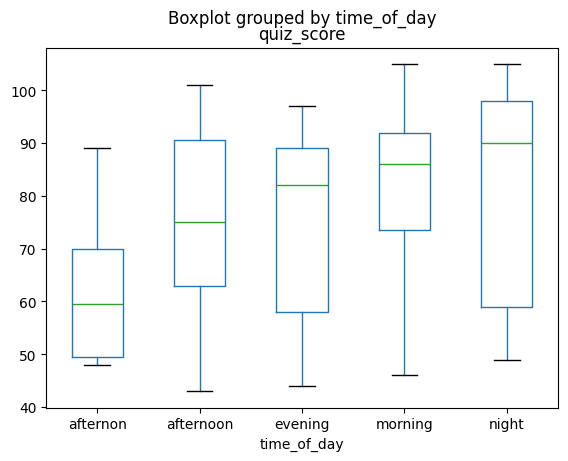

<Figure size 1000x600 with 0 Axes>

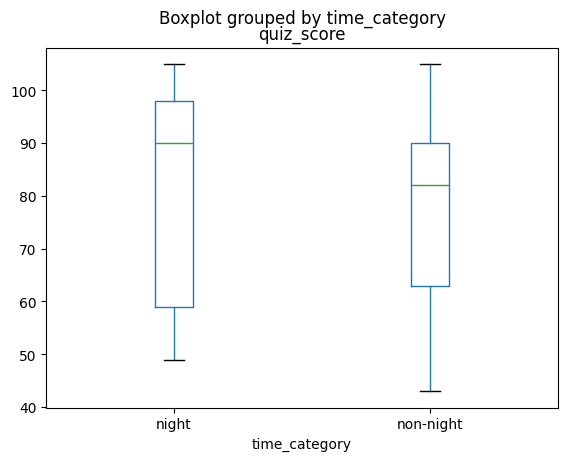

In [7]:
# Quiz score vs time_of_day (boxplot)
plt.figure(figsize=(10, 6))
df.boxplot(column='quiz_score', by='time_of_day', grid=False) 

# Quiz score vs study_hours (night vs non-night)
plt.figure(figsize=(10, 6))
df['time_category'] = np.where(df['time_of_day'] == 'night', 'night', 'non-night')
df.boxplot(column='quiz_score', by='time_category', grid=False)

In [8]:
df.describe()


,date,study_hours,break_minutes,focus_score,difficulty_level,topic_consistency,quiz_score
count,79,147.000000,147.000000,147.000000,146.000000,147.000000,147.000000
mean,2026-02-28 13:22:01.518987264,3.218702,24.952381,74.852113,2.013699,1.384490,78.387755
min,2026-01-01 00:00:00,1.500000,9.000000,45.000000,1.000000,0.440000,43.000000
25%,2026-01-29 12:00:00,2.500000,18.000000,64.500000,1.000000,0.610000,62.500000
50%,2026-02-28 00:00:00,3.218702,24.000000,76.000000,2.000000,0.810000,83.000000
75%,2026-03-30 00:00:00,3.900000,30.000000,85.500000,2.000000,0.900000,91.000000
max,2026-04-29 00:00:00,5.000000,52.000000,99.000000,4.000000,92.000000,105.000000
std,NaN,0.873474,9.782801,14.234796,0.870880,7.526753,16.946915


In [9]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 147 entries, 0 to 146
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   date               79 non-null     datetime64[ns]
 1   study_hours        147 non-null    float64       
 2   break_minutes      147 non-null    float64       
 3   focus_score        147 non-null    float64       
 4   difficulty_level   146 non-null    float64       
 5   time_of_day        147 non-null    object        
 6   topic_consistency  147 non-null    float64       
 7   quiz_score         147 non-null    float64       
 8   time_category      147 non-null    object        
dtypes: datetime64[ns](1), float64(6), object(2)
memory usage: 11.5+ KB


In [10]:
df.head(20)

,date,study_hours,break_minutes,focus_score,difficulty_level,time_of_day,topic_consistency,quiz_score,time_category
0,2026-01-01,3.500000,25.0,78.000000,2.0,morning,0.85,88.0,non-night
2,2026-01-03,2.750000,30.0,74.852113,2.0,afternoon,0.76,83.0,non-night
4,2026-01-05,3.000000,15.0,85.000000,2.0,night,0.94,89.0,night
5,2026-01-06,4.500000,24.0,74.852113,NaN,night,92.00,83.0,night
6,2026-01-07,2.250000,18.0,67.000000,1.0,afternoon,0.59,65.0,non-night
7,2026-01-08,5.000000,40.0,95.000000,4.0,morning,0.97,100.0,non-night
8,2026-01-09,3.300000,24.0,81.000000,2.0,evening,0.88,87.0,non-night
9,2026-01-10,2.000000,22.0,62.000000,1.0,afternon,0.55,58.0,non-night
10,2026-01-11,3.750000,35.0,74.852113,2.0,morning,0.80,84.0,non-night
12,2026-01-13,4.100000,30.0,89.000000,2.0,night,0.91,94.0,night
